In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm

import numpy as np
import os

import matplotlib.pyplot as plt

bands = [4,5,6,7,8,9]

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

2022-03-10 12:36:54.547774: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-03-10 12:36:54.547827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 70
max_number = 30
batch_size = 1
max_shift = 28
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=17

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [3]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    x_crop_start = int(round(pos[0] - (cutout_pixel_size-1)/2))
    x_crop_end = int(round(pos[0] + (cutout_pixel_size-1)/2))
    
    y_crop_start = int(round(pos[1] - (cutout_pixel_size-1)/2))
    y_crop_end = int(round(pos[1] + (cutout_pixel_size-1)/2))
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [4]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

(6, 350, 350)

input_image


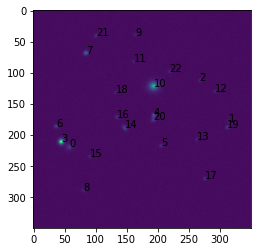

In [5]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


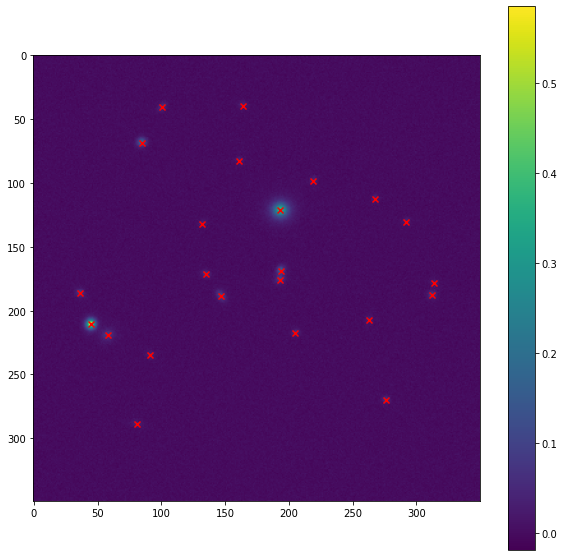

In [6]:
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2]/80000)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
fig.colorbar(im1, ax=ax)

In [10]:
import time
nb_gal = []
time_per_itr = []
for i in range(10):
    detected_positions = []
    blend = next(draw_generator)

    blend['blend_list'][0]['x_peak']

    np.shape(blend['blend_images'][0])

    for i in range(len(blend['blend_list'][0])):
        detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])
    print(detected_positions)

    t0 = time.time()
    deb = Deblend(blend['blend_images'][0]/80000, detected_positions, num_components=len(blend['blend_list'][0]), use_likelihood=True)
    time_per_itr.append(time.time()-t0)
    nb_gal.append(len(detected_positions))
    print(time.time()-t0)
    print(len(detected_positions))
    del(blend)

[[142.32890536483228, 202.9225652113555], [279.4577888209726, 76.06416135501348], [304.64453395546207, 98.7508218045503], [109.67302961648744, 95.85046569452662], [127.9805431140366, 46.717781257364564], [151.69001385041992, 150.3557692014169], [304.05042796169107, 47.3690678966167], [53.288592102761626, 288.83557644848236], [204.41864678814153, 208.93144111836713], [195.58283288258926, 127.8912103827833], [249.1958257409957, 108.58236517795912], [56.62501958461307, 240.94114297618268], [79.02269255369592, 286.0360244887909], [256.05968386542537, 313.0538591022215], [299.1834685280693, 58.038002970268764], [185.5183192373143, 159.17681944348172], [178.70858833310413, 306.98517348124165], [233.35687360845102, 198.89845765217626], [90.32097125753958, 258.6995161253219]]
in cropping
(350, 350, 6)
using encoder for initial point
158.01939368247986
19
[[143.71683729086666, 111.07081638113391], [45.612452066517136, 251.9310093924227], [103.07354134500163, 84.60465375694517], [94.879080404954

In [11]:
print(time_per_itr)

[158.0193886756897, 117.87220549583435, 121.52136015892029, 95.45182967185974, 159.95482563972473, 162.19975972175598, 138.31792283058167, 70.71512222290039, 147.7782371044159, 197.06770133972168]


In [12]:
print(nb_gal)

[19, 10, 11, 5, 18, 20, 14, 1, 15, 25]


Text(0.5, 0, 'nb of galaxies')

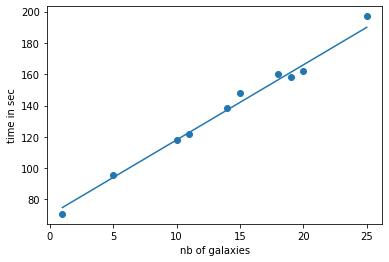

In [23]:
plt.scatter(nb_gal, time_per_itr)
x=np.arange(25)+1
y=4.8*x+70
plt.plot(x,y)
plt.ylabel("time in sec")
plt.xlabel("nb of galaxies")

so it takes around 4.8 seconds per galaxy (80 times slower than first implementation of SCARLET)\
Here I am doing 200 iterations with lr of 0.3\
Note: This benchmarking has been done on CPU using the Jupyter notebook server at CCin2p3